### Libraries

In [1]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob
#!pip install git+https://github.com/facebookresearch/fvcore.git

In [2]:
pwd

'/scratch/student/shokoofa'

In [3]:
original_address = '/scratch/student/shokoofa/'
# '/home/zahra.ghods'
# '/home/student/shokoofa/Downloads/dataset/'
# 'C:/echo/dataset
# '/scratch/student/shokoofa/'

In [4]:
paths = glob.glob(os.path.join(original_address + '/dataset/**/*', '*')) #numebr of all samples per patients
len(paths)

5303

### Load the csv file containing the image file names and corresponding labels

In [5]:
info_train = pd.read_csv(os.path.join(original_address , 'train_labels.csv'))
info_val = pd.read_csv(os.path.join(original_address , 'val_labels.csv'))
info_test = pd.read_csv(os.path.join(original_address , 'test_labels.csv'))

In [8]:
info_train['path'][100], info_train['label'][100]

('Train/6fwt32TiT_KD-QU8t64_eg/82', 'Subcostal')

### Preprocessing

### Define Transformers

In [9]:
class CustomCrop(object):
    """Crops the bottom 1/10 of the height and 1/8 of the width of the image."""
    def __call__(self, img):
        w, h = img.size
        new_h = h - h // 15
        top = 0
        left = w // 10
        return img.crop((left, top, w, new_h))

train_transform = transforms.Compose([
    CustomCrop(),
    # transforms.Resize((224, 224)),
    #  transforms.Resize((256, 256)),
    transforms.Resize((299, 299)), # JUST FOR INCEPTION
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225]),
    # Lambda(lambda x: x/255)
])


### Map images to their labels

In [41]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, starts, ends, transform=None):
        self.paths = paths
        self.labels = labels
        self.starts = starts
        self.ends = ends
        self.transform = transform
        self.valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

    def __len__(self):
        return len(self.paths)

    def preprocessing(self, image_array, k = 100):
        slices, ch, height, width = image_array.shape

        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(k, slices)
        for i in range(steps - 1):
            mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1

        output = image_array * mask
        return output

    def address(self,index):
        return original_address + '/dataset/' + self.paths[index]
    
                
    def __getitem__(self, index):
        # Get the filename and label for the current index
        filepath = original_address + '/dataset/' + self.paths[index]
        label = self.labels[index]
        label = torch.tensor([self.valid_labels[str(label)]])


        # sort the image in based on the order of the slices saved in the folder
        # imgs_paths = sorted(glob.glob(os.path.join(filepath, '*')), key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))
        addresses = []
        for i in range(self.starts[index], self.ends[index]+1):
            addresses.append(filepath + '/' + filepath.split('/')[-1] + '_' + str(i) + '.jpeg')

        imgs_paths = sorted(addresses, key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))

        images_list = []
        for img_path in imgs_paths:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images_list.append(image)


        # creating a 3D tensor image
        sequence_tensor = torch.stack(images_list)
        # chunks = self.sliding_window(sequence_tensor)
        
        preprocessed_d = self.preprocessing(sequence_tensor)

        # Return the image and label as tensors
        return preprocessed_d, label

    # def number_of_classes(self):
    #   return self.data[:,1].max() + 1

In [32]:
# def window_sliding(im_list):
#             slided_list = []
#             for i in range(0,22): # 11 iteration for the maximum slide number which is 110 -> 22*5, 11*10  
                
#                 if len(im_list) >= (self.window_size + (i*5)):
#                     ls = im_list[i*5:(self.window_size + (i*5))]
#                     ls = torch.from_numpy(np.stack(ls))
#                     slided_list.append(ls)
                    
#                 else:
#                     # print(len(im_list), len(slided_list), self.window_size + ((i-1) *5))
#                     return slided_list

In [42]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  # im = Image.fromarray(image.permute(1,2,0))
  # plt.imshow(image.permute(1,2,0))
  plt.imshow(image, cmap= 'gray')
  plt.title(label)
  # plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Load the train dataset from the folder

In [47]:
train_data = CustomDataset(info_train['path'], info_train['label'],info_train['start'], info_train['end'], transform=train_transform)
val_data = CustomDataset(info_val['path'], info_val['label'],info_val['start'], info_val['end'], transform=train_transform)
test_data = CustomDataset(info_test['path'], info_test['label'],info_test['start'], info_train['end'], transform=train_transform)

In [44]:
train_data[10]

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0

In [46]:
len(train_data)

15384

/scratch/student/shokoofa//dataset/Train/6fwt32TiT_KD-QU8t64_eg/47


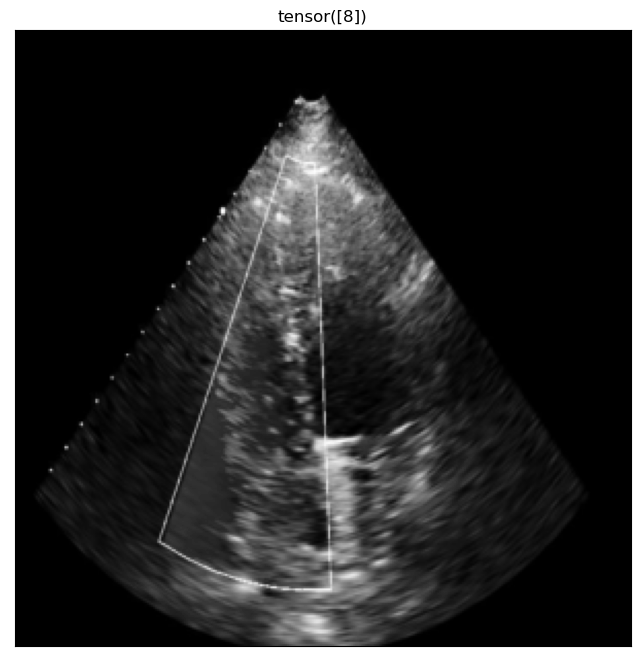

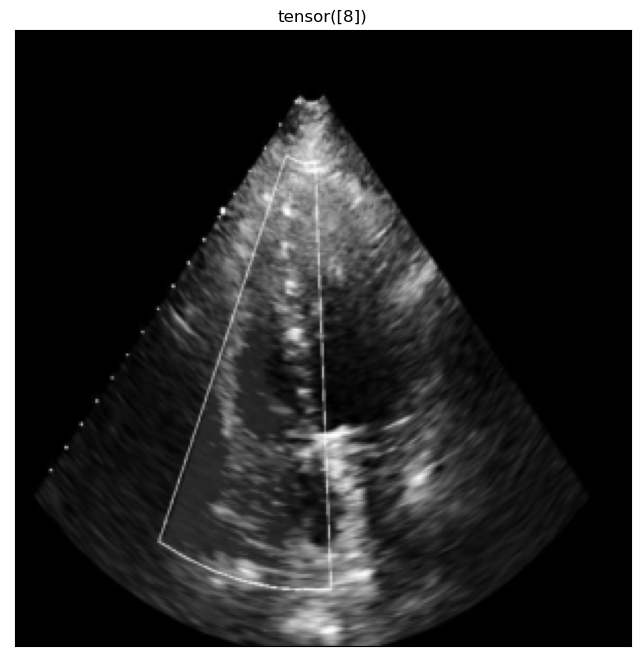

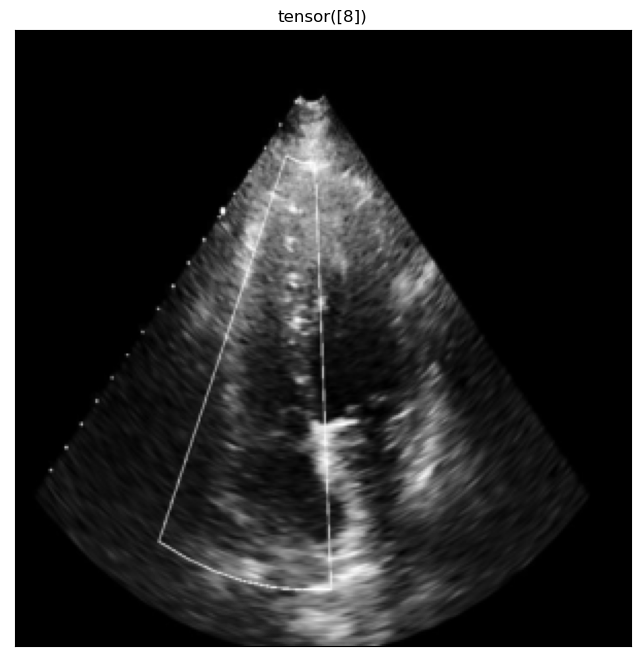

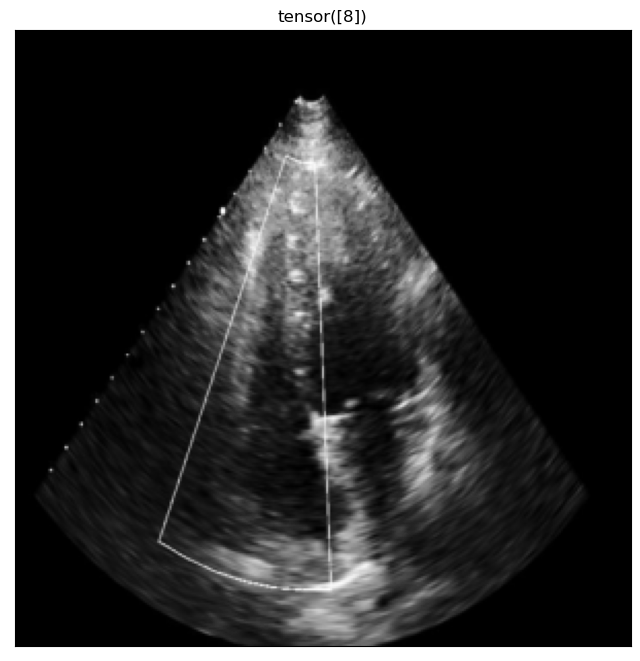

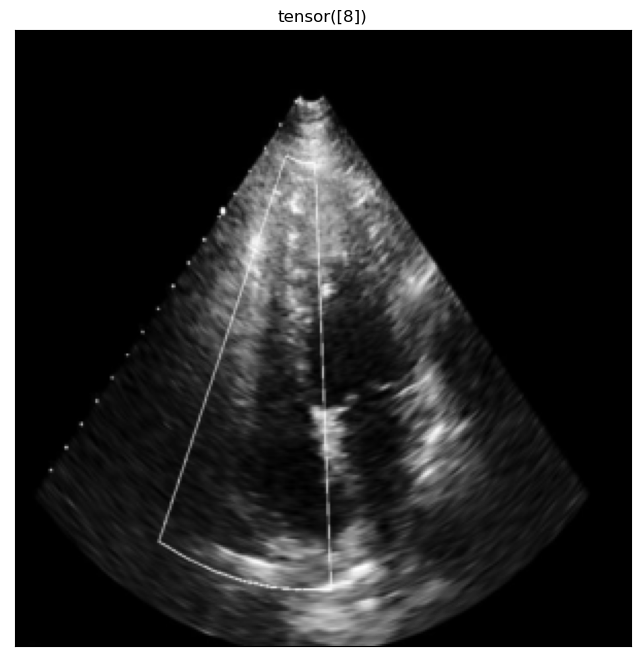

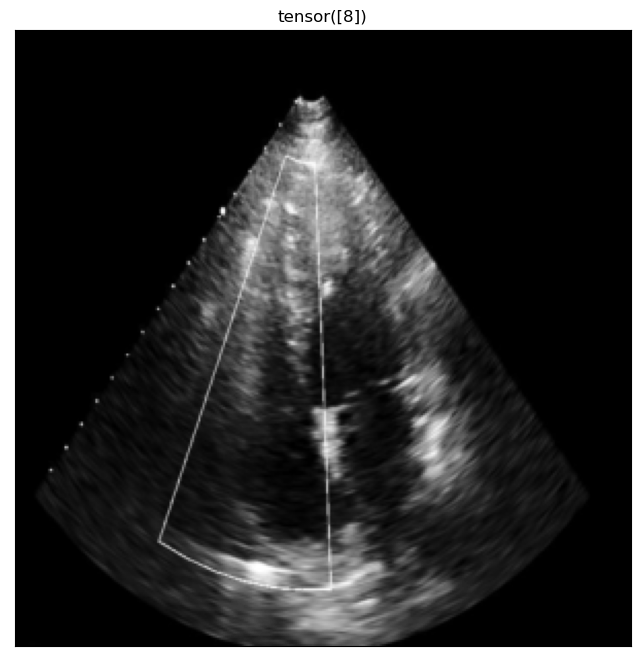

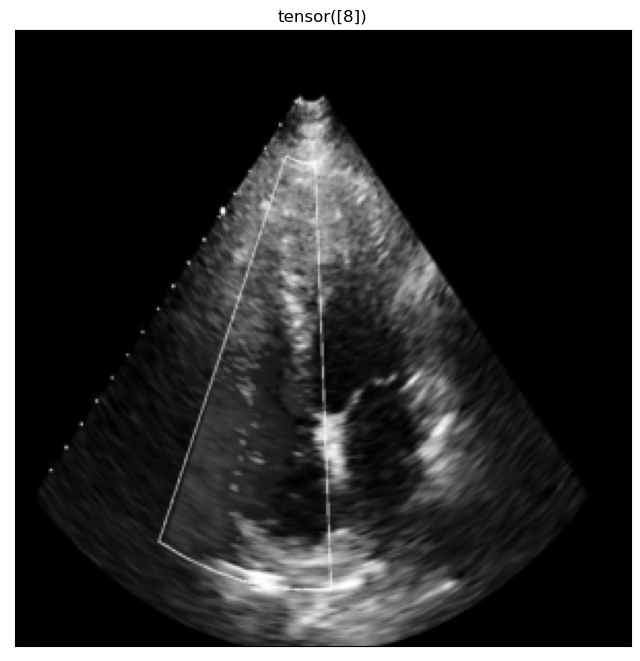

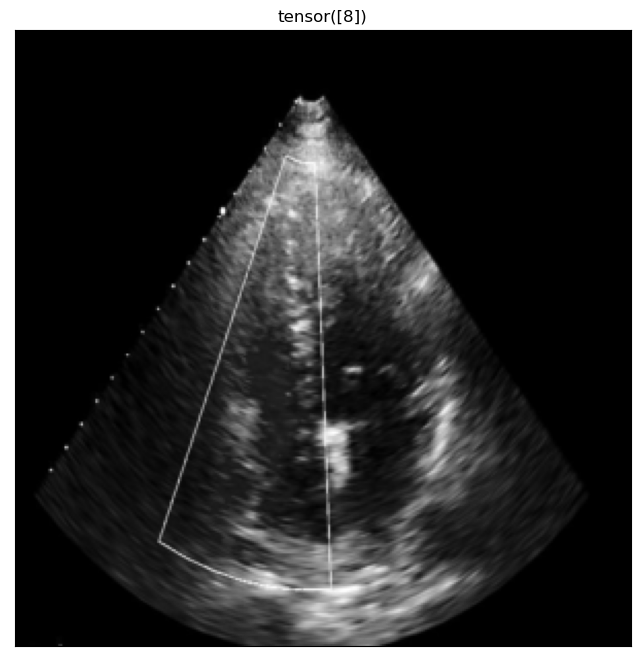

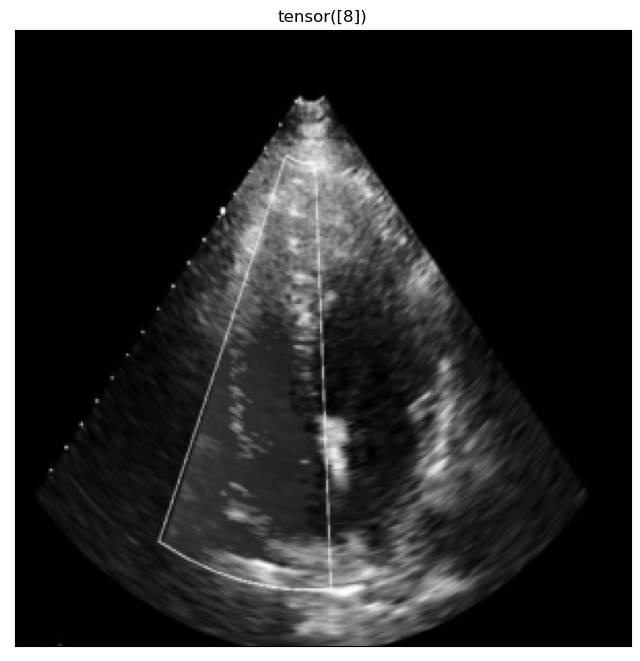

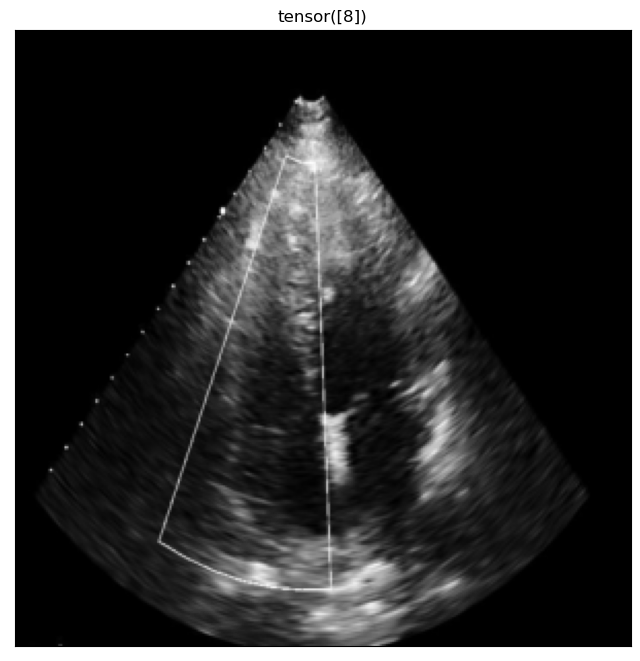

In [45]:
print(train_data.address(10))
for i in range(len(train_data[10][0][:])):
    visualization(train_data[10][0][i,-1], train_data[10][1])

### Split the data into train, test and validation sets

In [24]:
# total_len = len(total_data)
# train_len = int(total_len * 0.8)
# test_len = total_len - train_len

# data, test_data = random_split(total_data, [train_len, test_len])

In [25]:
# total_len = len(data)
# train_len = int(total_len * 0.8)
# val_data = total_len - train_len

# train_data, val_data = random_split(data, [train_len, val_data])

In [119]:
# def collate_fn(data_input):
#     data, labels = zip(*data_input)
#     window_size = 10
#     window_sliding = 5

#     slided_list = []
#     label_list = []

#     for d, l in zip(data, labels):
#         i = 0
#         # for i in range(0,22): # 11 iteration for the maximum slide number which is 110 -> 22*5, 11*10       
#         while( len(d) >= (window_size + (i*window_sliding)) and i < 2):
#             ls = d[i*window_sliding:(window_size + (i*window_sliding))]
#             # ls = torch.from_numpy(np.stack(ls))
#             slided_list.append(ls)
#             label_list.append(l)
#             i += 1
#     slided_list = torch.stack(slided_list)
#     label_list = torch.stack(label_list)

#     return slided_list, label_list
   

### Create data loaders for the train and validation sets



In [48]:
train_loader = DataLoader(train_data, batch_size=32, drop_last=True, shuffle=True, pin_memory=True, num_workers= 8, persistent_workers=True)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 8, persistent_workers=True)
# collate_fn=collate_fn)
# #pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 8, persistent_workers=True)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [122]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    break
    # print(i)
# #     print(images[0].shape, images[-1].shape, '\n')

torch.Size([59, 10, 3, 299, 299])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4e4d90d30>
Traceback (most recent call last):
  File "/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/student/shokoofa/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe4e4d90d30>
Traceback (most recent call last):
  File "/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/student/shokoofa/anaconda3/lib/python3.9/site-p

### Define the neural network model architecture

In [49]:
class CNN3D(nn.Module):
    def __init__(self, cnn_output_size, num_classes):
        super(CNN3D, self).__init__()

        self.num_classes = num_classes
        self.cnn_output_size = cnn_output_size

        self.conv3 = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)
        self.classifier_layer = nn.Sequential( nn.Linear(self.cnn_output_size, num_classes))

    def forward(self, x):
        batch_size , seq_len, C, H, W = x.size()
        c_in = x.view( batch_size, C, seq_len, H, W)
        # print(c_in.shape)
        c_out = self.conv3(c_in)
        C_out = c_out.view(batch_size, -1)
        output = self.classifier_layer(c_out)
        return output


cnn_output_size = 400
model = CNN3D(cnn_output_size, 11)

Using cache found in /home/student/shokoofa/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [20]:
# # input1 = torch.rand(8, 10, 3, 254, 254)
# input2 = torch.rand(8, 10, 3, 299, 299)
# # # model.eval()
# print(model(input2))
# # print(model(input2))

### Define loss and optimizer

In [50]:
torch.cuda.is_available()
# !export CUDA_VISIBLE_DEVICES=0

True

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")

  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1, momentum=0.9)

print(device)

Let's use 2 GPUs!
cuda


### Train the model

In [52]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) #TODO: if number of sampels increase more than one it SHOULD increase as well
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      # print(predictions, labels, labels == predictions, total_correct, total, images.size(0))

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss



In [53]:
# model = model.to(device)
epochs = 60
# BATCH_SIZE = 64
accs = []
losses = []
for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  val_loss = 0.0
  # epochs_no_improve = 0
  best_val_loss = - float('inf')
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    # print(images)
    # print(outputs)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    # print(predictions, labels)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()
    # total_loss += loss.item() * images.size(0)
  #   if (i%10 == 0):
  #     print(total_loss/total)
  # accuracy = total_correct / total
    # break
  if (epoch%10 == 0):
    torch.save(model.state_dict(), (f'/scratch/student/shokoofa/cnn3dmodel{epoch}.pth'))

  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, criterion, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss > best_val_loss):
    best_val_loss = val_loss
    epochs_no_improve = 0
    
  else:
    epochs_no_improve += 1
    

  if epochs_no_improve > 5:
    torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/rcnn3d_model{epoch}.pth'))
    print('no further improvement')
    break


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_220194/3074905716.py", line 15, in forward
    c_out = self.conv3(c_in)
  File "/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/student/shokoofa/.cache/torch/hub/facebookresearch_pytorchvideo_main/pytorchvideo/models/net.py", line 43, in forward
    x = block(x)
  File "/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/student/shokoofa/.cache/torch/hub/facebookresearch_pytorchvideo_main/pytorchvideo/models/resnet.py", line 1399, in forward
    x = res_block(x)
  File "/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/student/shokoofa/.cache/torch/hub/facebookresearch_pytorchvideo_main/pytorchvideo/models/resnet.py", line 1186, in forward
    x = self.branch_fusion(shortcut, self.branch2(x))
  File "/home/student/shokoofa/.cache/torch/hub/facebookresearch_pytorchvideo_main/pytorchvideo/models/resnet.py", line 323, in _trivial_sum
    return x + y
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 880.00 MiB (GPU 0; 47.54 GiB total capacity; 7.10 GiB already allocated; 313.56 MiB free; 7.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


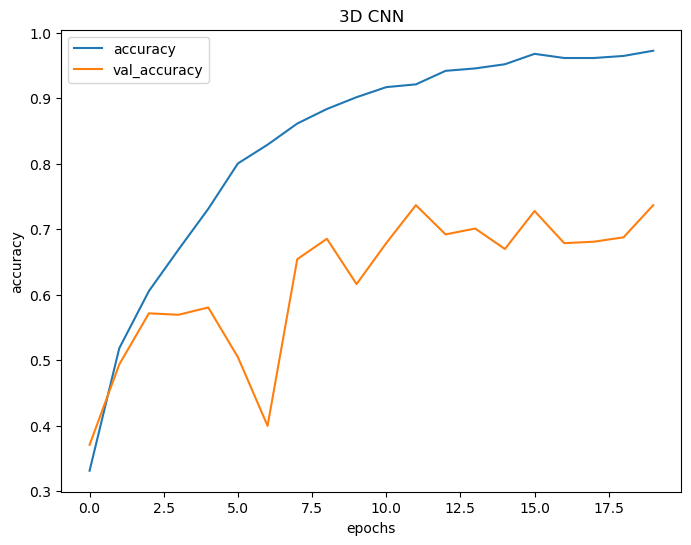

In [25]:
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt
import numpy as np


# Generate sample data
x = [i for i in range(0,len(accs)//2)]
y = [accs[i].cpu() for i in range(0,len(accs),2)]
z = [accs[i].cpu() for i in range(1,len(accs),2)]


# Create a new figure and set the size
fig = plt.figure(figsize=(8, 6))

# Add a new subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the line graph
ax.plot(x, y, label='accuracy')
ax.plot(x, z, label='val_accuracy')
ax.legend()
# Set the title and axis labels
ax.set_title('3D CNN')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

# Display the plot
plt.show()


In [ ]:
# predictions == labels

In [ ]:
# model.load_state_dict(torch.load('/home/student/shokoofa/Downloads/model0.pth'))
# model.eval()

In [ ]:
# print(model(test_data[183][0].unsqueeze(0).to(device)))
# # test_data[0][0].unsqueeze(0).shape
# # images.size()

# test_data[183][1]

In [ ]:
# class CNN(nn.Module):
#     def __init__(self, in_channels):
#         super(CNN, self).__init__()

#         self.conv = EfficientNet.from_pretrained('efficientnet-b0')
#         self.conv.trainable = False
#         for param in self.conv.parameters():
#             param.requires_grad = False

#     def forward(self, x):
#         seq_len, C, H, W = x.size()
#         c_in = x.view( seq_len, C, H, W)
#         c_out = self.conv.extract_features(c_in)
#         pooled = F.adaptive_avg_pool2d(c_out, (1,1))
#         pooled = pooled.view(seq_len, -1)
#         return pooled


# # x = torch.rand((1, 20, 1, 32, 32))
# xx = [torch.rand( i, 3, 224, 224) for i in range(25,30)]
# net_cnn = CNN(1)
# for x in xx:
#     features = net_cnn(x)
#     print(features.shape)

In [ ]:
# class VGG(nn.Module):
#   def __init__(self, num_classes=100):
#     super().__init__()
#     self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#     )

#     self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((6, 6))
#     self.flatten = nn.Flatten(start_dim=1)
#     self.classifier = nn.Sequential(
#             nn.Linear(256*256*512, num_classes),
#             nn.ReLU(inplace=True),
#             # nn.Linear(1000, 100),
#             # nn.ReLU(inplace=True),
#             # nn.Linear(1000, num_classes),
#             # nn.ReLU(inplace=True),
#         )

#   def forward(self, x):
#     x = self.features(x)
#     # x = self.adaptive_avg_pool2d(x)
#     x = self.flatten(x)
#     x = self.classifier(x)
#     return x

In [ ]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break

In [ ]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break



In [ ]:
# torch.save(model.state_dict(), 'model.pt')
